<a href="https://colab.research.google.com/github/danialkhan02/MLApparelPredictor/blob/main/googlenet_baseline_model_Apparel_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   Data Loading and Splitting



In [1]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
import os
from tabulate import tabulate
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent
import torchvision
from torchvision import datasets, models, transforms

torch.manual_seed(1) # set the random seed

In [3]:
# define the training, validation, testing directories
data_dir = "/content/gdrive/My Drive/images/MyersSet/"
training_data_dir = os.path.join(data_dir, "small_dataset_training")
validation_data_dir = os.path.join(data_dir, "small_dataset_validation")
testing_data_dir = os.path.join(data_dir, "small_dataset_testing")

classes = ["dress",
"high+heels",
"mens+shorts",
"mens+suit+jacket",
"mens+tshirt",
"sunglasses",
"watches",
]

In [4]:
# Load and Transform using ImageFolder

# 244 x 244 pixels for the images, each image needs to be resized to be used later in the network
data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor()])

# generic data loader for taking in the datasets and using it for the network
training_data_set = torchvision.datasets.ImageFolder(root=training_data_dir, transform=data_transform)
validation_data_set = torchvision.datasets.ImageFolder(root=validation_data_dir, transform=data_transform)
testing_data_set = torchvision.datasets.ImageFolder(root=testing_data_dir, transform=data_transform)


In [5]:
# Check out the number of data samples for training, validation, testing data
num_training_data = len(training_data_set)
num_val_data = len(validation_data_set)
num_testing_data = len(testing_data_set)

data = [["Training", num_training_data],
        ["Validation", num_val_data],
        ["Testing", num_testing_data],
        ["Total", (num_training_data + num_val_data + num_testing_data)]]

col_names = ["Type of Data", "Number of Data Samples"]

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))


╒════════════════╤══════════════════════════╕
│ Type of Data   │   Number of Data Samples │
╞════════════════╪══════════════════════════╡
│ Training       │                      147 │
├────────────────┼──────────────────────────┤
│ Validation     │                       70 │
├────────────────┼──────────────────────────┤
│ Testing        │                      118 │
├────────────────┼──────────────────────────┤
│ Total          │                      335 │
╘════════════════╧══════════════════════════╛


In [6]:
# define dataloader parameters
batch_size  = 55
num_workers = 0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(training_data_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data_set, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

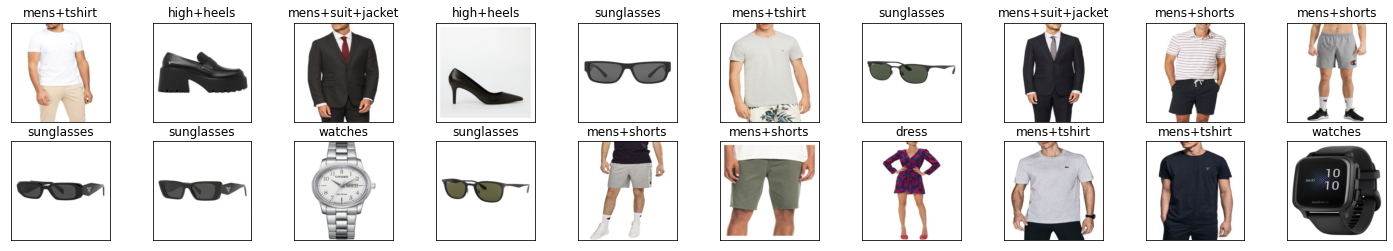

In [7]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

Baseline Convolutional Network

In [ ]:
#Convolutional Neural Network Architecture
class CNN_ML_Apparel(nn.Module):
    def __init__(self):
        super(CNN_ML_Apparel, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size, string = 1, padding = 0
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(53*53*10, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 53*53*10)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    print('Convolutional Neural Network Architecture Done')


Convolutional Neural Network Architecture Done


The general formula is this if you are interested: $[(W−K+2P)/S]+1$.

* $W$ is the input volume 
* $K$ is the Kernel size 
* $P$ is the padding 
* $S$ is the stride

==============================================================

* $28\times 28$ (1ch) => conv1 => $24\times24$ (5ch) --- (28-5+1)
* $24\times24$ (5ch) => pool => $12\times12$ (5ch)
* $12\times12$ (5ch) => conv2 => $8\times8$ (10ch)
* $8\times8$ (10ch) => pool => $4\times4$ (10ch)
* $4\times4$ (10ch)  => Flat => $4\times4\times10 = 160$


**Training the Data**

In [ ]:
def get_accuracy(model, train=False, batch_size=27):
    if train:
        data = training_data_set
    else:
        data = validation_data_set

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, data, batch_size=25, num_epochs=150, learn_rate=0.001, momentum=0.9):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    # Load in the data from fed into function
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)

    iters, losses, train_acc, val_acc = [], [], [], []

    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss

            train_acc.append(get_accuracy(model, train=True, batch_size=batch_size)) # compute training accuracy 
            val_acc.append(get_accuracy(model, train=False, batch_size=batch_size))  # compute validation accuracy
            n += 1
        print(("Iteration (Epoch):", epoch, "Train accuracy:"), train_acc[-1])

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

**Overfit to the small myers dataset**

CNN
CUDA is available!  Training on GPU ...
CNN_ML_Apparel(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28090, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
('Iteration (Epoch):', 0, 'Train accuracy:') 0.1360544217687075
('Iteration (Epoch):', 1, 'Train accuracy:') 0.2925170068027211
('Iteration (Epoch):', 2, 'Train accuracy:') 0.2789115646258503
('Iteration (Epoch):', 3, 'Train accuracy:') 0.20408163265306123
('Iteration (Epoch):', 4, 'Train accuracy:') 0.3333333333333333
('Iteration (Epoch):', 5, 'Train accuracy:') 0.5578231292517006
('Iteration (Epoch):', 6, 'Train accuracy:') 0.5374149659863946
('Iteration (Epoch):', 7, 'Train accuracy:') 0.5510204081632653
('Iteration (Epoch):', 8, 'Train accuracy:') 0.5102040816326531
('Iteration (Epoch):', 9, 'Train a

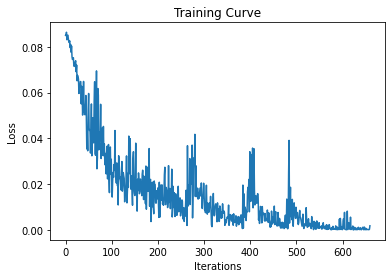

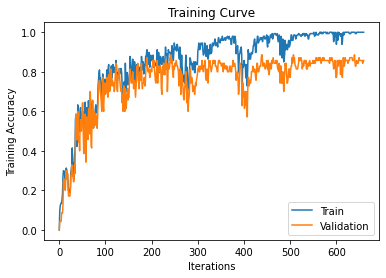

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.8571428571428571


In [ ]:
print("CNN")
model = CNN_ML_Apparel()
use_cuda = True

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
print(model)


train(model, training_data_set,  num_epochs=110, batch_size=27, learn_rate=0.001, momentum=0.9)

Test the baseline model accuracy.

In [ ]:
def get_test_accuracy(model, batch_size):
    data = testing_data_set
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        
        
        #############################################
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        
        output = model(imgs)
        
        # Select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
test_acc = get_test_accuracy(model, batch_size=27)
print("The test accuracy is", test_acc*100, "%.")

The test accuracy is 85.59322033898306 %.



**AlexNet**


In [26]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [7]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [8]:
# Directories used to store the pre-trained features 
feature_dir = '/content/gdrive/MyDrive/images/features/'  # Change the directory if necessary 
train_feature_dir = os.path.join(feature_dir, 'training_features/')
val_feature_dir = os.path.join(feature_dir, 'validation_features/')
test_feature_dir = os.path.join(feature_dir, 'testing_features/')

In [9]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...

# Data Loader used for training, validation data
train_loader = torch.utils.data.DataLoader(training_data_set, batch_size=1, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data_set, batch_size=1, 
                                           shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing_data_set, batch_size=1, 
                                           shuffle=True)

print(train_loader)
print(val_loader)
print(testing_loader)

# Save the computed features for the training and validation set 

n = 0 
for img, label in iter(train_loader): 
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  print(train_feature_dir + str(classes[label]))

  tensor_features_to_save = features_tensor.squeeze(0)

  torch.save(tensor_features_to_save, train_feature_dir + str(classes[label]) + '/' + str(n) + '.tensor')
  n += 1

n = 0 
for img, label in iter(val_loader): 
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  print(val_feature_dir + str(classes[label]))

  tensor_features_to_save = features_tensor.squeeze(0)

  torch.save(tensor_features_to_save, val_feature_dir + str(classes[label]) + '/' + str(n) + '.tensor')
  n += 1

n = 0 
for img, label in iter(testing_loader): 
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())

  print(test_feature_dir + str(classes[label]))

  tensor_features_to_save = features_tensor.squeeze(0)

  torch.save(tensor_features_to_save, test_feature_dir + str(classes[label]) + '/' + str(n) + '.tensor')
  n += 1

/content/gdrive/MyDrive/images/features/training_features/watches


KeyboardInterrupt: ignored

In [10]:
# Reload the pre-trained features 
train_features = torchvision.datasets.DatasetFolder(train_feature_dir, loader=torch.load, extensions=('.tensor'))
train_features_loader = torch.utils.data.DataLoader(train_features, batch_size=batch_size, shuffle=True) 
val_features = torchvision.datasets.DatasetFolder(val_feature_dir, loader=torch.load, extensions=('.tensor'))
val_features_loader = torch.utils.data.DataLoader(val_features, batch_size=batch_size, shuffle=True)


In [11]:
class transfer_CNN(nn.Module):
    def __init__(self):
        super(transfer_CNN, self).__init__()
        self.name = "transfer_cnn"
        self.conv1 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear( 3 * 256 * 3, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 3 * 256 * 3)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x  

In [12]:
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [13]:
def get_accuracy_alexnet(model, train=False, batch_size=27):
    if train:
        data = train_features
    else:
        data = val_features

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [14]:
def train_alexnet(model, data, batch_size=64, num_epochs=30, learn_rate=0.001, momentum=0.9):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    plotIteration = range(1, num_epochs + 1)
    # Load in the data from fed into function
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)

    iters, losses, train_acc, val_acc = [], [], [], []

    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            n += 1

        train_acc.append(get_accuracy_alexnet(model, train=True, batch_size=batch_size)) # compute training accuracy 
        val_acc.append(get_accuracy_alexnet(model, train=False, batch_size=batch_size))  # compute validation accuracy
            
        print(("Iteration (Epoch):", epoch, "Train accuracy:"), train_acc[-1])
        model_path = get_model_name(model.name, batch_size, learn_rate, epoch)
        torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(plotIteration, train_acc, label="Train")
    plt.plot(plotIteration, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

CUDA is available!  Training on GPU ...
('Iteration (Epoch):', 0, 'Train accuracy:') 0.22448979591836735
('Iteration (Epoch):', 1, 'Train accuracy:') 0.4489795918367347
('Iteration (Epoch):', 2, 'Train accuracy:') 0.41496598639455784
('Iteration (Epoch):', 3, 'Train accuracy:') 0.4217687074829932
('Iteration (Epoch):', 4, 'Train accuracy:') 0.5578231292517006
('Iteration (Epoch):', 5, 'Train accuracy:') 0.7619047619047619
('Iteration (Epoch):', 6, 'Train accuracy:') 0.8843537414965986
('Iteration (Epoch):', 7, 'Train accuracy:') 0.9523809523809523
('Iteration (Epoch):', 8, 'Train accuracy:') 0.9523809523809523
('Iteration (Epoch):', 9, 'Train accuracy:') 0.9727891156462585
('Iteration (Epoch):', 10, 'Train accuracy:') 0.9727891156462585
('Iteration (Epoch):', 11, 'Train accuracy:') 0.9795918367346939
('Iteration (Epoch):', 12, 'Train accuracy:') 0.9863945578231292
('Iteration (Epoch):', 13, 'Train accuracy:') 0.9863945578231292
('Iteration (Epoch):', 14, 'Train accuracy:') 0.9795918367

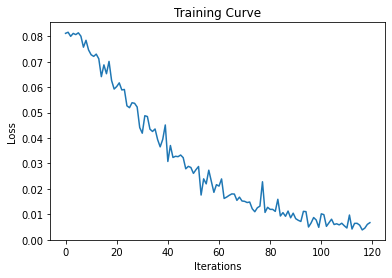

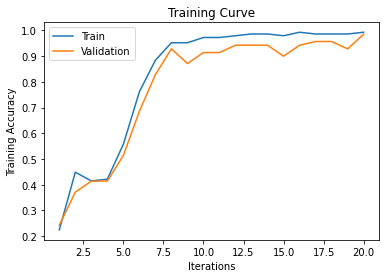

Final Training Accuracy: 0.9931972789115646
Final Validation Accuracy: 0.9857142857142858


In [15]:
# Train the AlexNet by tuning hyperparameters 
use_cuda = True

alexnet_model = transfer_CNN()

if use_cuda and torch.cuda.is_available():
  alexnet_model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train_alexnet(alexnet_model, train_features, batch_size=27, num_epochs=20)


In [16]:
test_features = torchvision.datasets.DatasetFolder(test_feature_dir, loader=torch.load, extensions=('.tensor'))
test_features_loader = torch.utils.data.DataLoader(test_features, batch_size=batch_size, shuffle=True)


In [17]:
def get_test_accuracy_alexnet(model, batch_size):
    data = test_features
    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=batch_size):
        
        
        #############################################
        # To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        
        output = model(imgs)
        
        # Select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [18]:
test_acc = get_test_accuracy_alexnet(alexnet_model, batch_size=27)
print("The test accuracy is", test_acc*100, "%.")

The test accuracy is 95.76271186440678 %.


**Demonstration**

In [24]:
demos_dir = '/content/gdrive/MyDrive/images/Demos/' 
dataset = datasets.ImageFolder(demos_dir, transform=data_transform)
demos_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [29]:
# Demonstrate the Baseline model 
prediction = [] 
for image, label in demos_loader: 
  prediction.append(F.softmax(model(image.cuda())).tolist())

# obtain one batch of training images
dataiter = iter(demos_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ["dress",
"high+heels",
"mens+shorts",
"mens+suit+jacket",
"mens+tshirt",
"sunglasses",
"watches",
]

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 15))
for idx in range(len(images)):
  # Printing out prediction
  print("Prediction: " + classes[prediction[0][idx].index(max(prediction[0][idx]))] 
                + "\nConfidence Score: %2.3f" % (max(prediction[0][idx]) * 100) + "%")
  print()


  ax = fig.add_subplot(4, 20/6.5, idx+1, xticks=[], yticks=[])

  # Plotting Results
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title("Label: " + classes[labels[idx]], fontsize=11)
  ax.set_xlabel("Prediction: " + classes[prediction[0][idx].index(max(prediction[0][idx]))] 
                  + "\nConfidence Score: %2.3f" (max(prediction[0][idx]) * 100) + "%", fontsize=7)

NameError: ignored

In [27]:
classes = ["dress",
"high+heels",
"mens+shorts",
"mens+suit+jacket",
"mens+tshirt",
"sunglasses",
"watches",
]

In [28]:
# Demonstration of AlexNet
alexDemo_dir = '/content/gdrive/MyDrive/images/Demos/'
alexDemo_loader = torch.utils.data.DataLoader(dataset, batch_size=1)


In [29]:
# Features for Demo
n = 0 
for img, label in iter(alexDemo_loader): 
  features = alexnet.features(img).cuda()
  features_tensor = torch.from_numpy(features.cpu().detach().numpy())
  torch.save(features_tensor.squeeze(0), alexDemo_dir + str(classes[label]) + '/' + str(n) + '.tensor')
  n += 1

In [30]:
alexDemo_features = torchvision.datasets.DatasetFolder(alexDemo_dir, loader=torch.load, extensions=('.tensor'))
alexDemo_features_loader = torch.utils.data.DataLoader(alexDemo_features, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


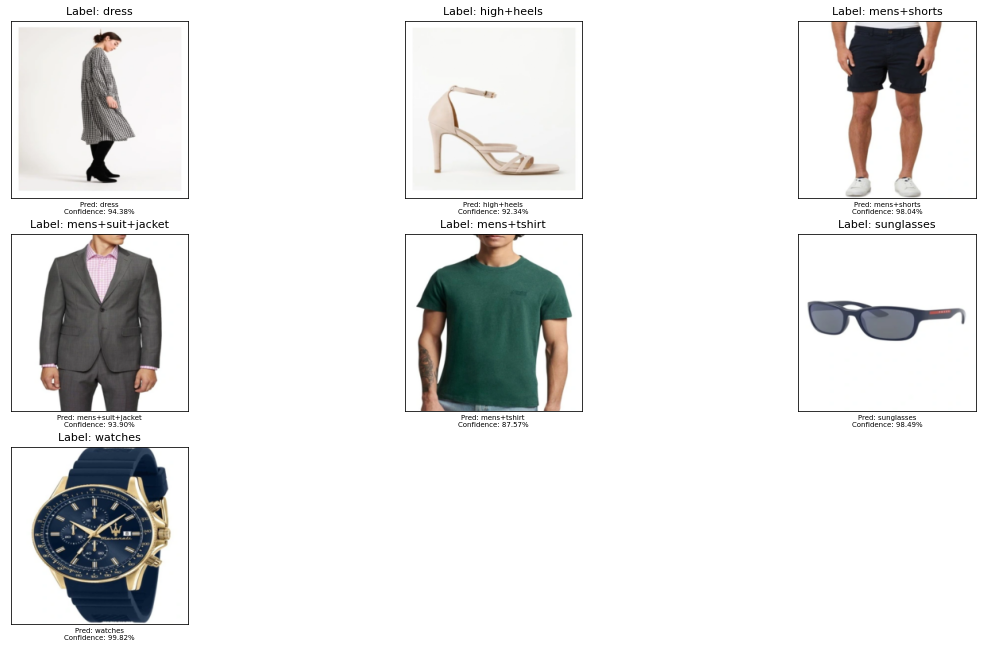

In [31]:
# Demonstration of AlexNet
# Demonstrate the primary AlexNet model 
alex_demon_dir = '/content/gdrive/MyDrive/images/Demos/'
alex_demon_loader = torch.utils.data.DataLoader(dataset, batch_size=1)

# Compute features for the demonstration images 
n = 0 
for img, label in iter(alex_demon_loader): 
  if use_cuda and torch.cuda.is_available():
    features = alexnet.features(img).cuda()
    features_tensor = torch.from_numpy(features.cpu().detach().numpy())
  else: 
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())
  
  folder_dir = alex_demon_dir + str(classes[label])
  if not os.path.isdir(folder_dir):
    os.mkdir(folder_dir)
  torch.save(features_tensor.squeeze(0), folder_dir + '/' + str(n) + '.tensor')
  n += 1

# Reload the computed features 
alex_demon_features = torchvision.datasets.DatasetFolder(alex_demon_dir, loader=torch.load, extensions=('.tensor'))
alex_demon_features_loader = torch.utils.data.DataLoader(alex_demon_features, batch_size=batch_size)

pred = [] 
for image, label in alex_demon_features_loader: 
  pred.append(F.softmax(alexnet_model(image.cuda())).tolist())

# obtain one batch of training images
dataiter = iter(demos_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 15))
for idx in range(len(images)):
    ax = fig.add_subplot(4, 20/6.5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("Label: " + classes[labels[idx]], fontsize=11)
    ax.set_xlabel("Pred: " + classes[pred[0][idx].index(max(pred[0][idx]))] 
                  + "\nConfidence: %2.2f" % (max(pred[0][idx]) * 100) + "%", fontsize=7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


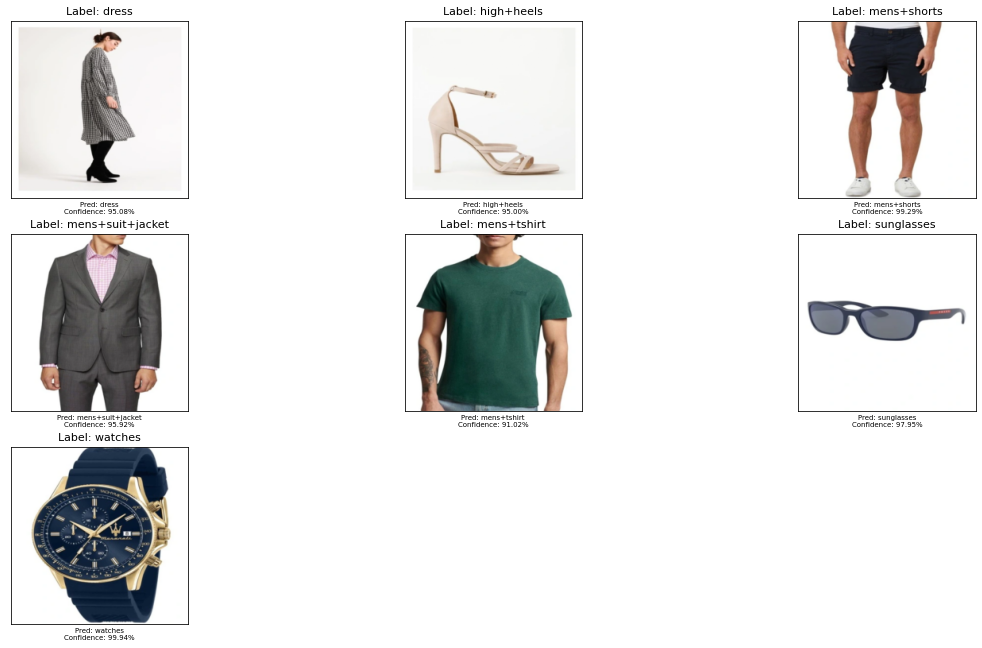

In [ ]:

dataiter = iter(demos_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 15))
for idx in range(len(images)):
    ax = fig.add_subplot(4, 20/6.5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("Label: " + classes[labels[idx]], fontsize=11)
    ax.set_xlabel("Prediction: " + classes[prediction[0][idx].index(max(prediction[0][idx]))] 
                  + "\nConfidence Score: %2.2f" % (max(prediction[0][idx]) * 100) + "%", fontsize=7)

**Loading in large dataset**

In [ ]:
# define the training, validation, testing directories
data_dir = "/content/gdrive/My Drive/images/MyersSet/"
large_training_data_dir = os.path.join(data_dir, "training")
large_validation_data_dir = os.path.join(data_dir, "validation")
large_testing_data_dir = os.path.join(data_dir, "testing")

In [ ]:
# generic data loader for taking in the datasets and using it for the network
data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.ToTensor()])

large_training_data_set = torchvision.datasets.ImageFolder(root=large_training_data_dir, transform=data_transform)
large_validation_data_set = torchvision.datasets.ImageFolder(root=large_validation_data_dir, transform=data_transform)
large_testing_data_set = torchvision.datasets.ImageFolder(root=large_testing_data_dir, transform=data_transform)


In [ ]:
# Check out the number of data samples for training, validation, testing data
num_training_data_L = len(large_training_data_set)
num_val_data_L = len(large_validation_data_set)
num_testing_data_L = len(large_testing_data_set)

data_L = [["Training", num_training_data_L],
        ["Validation", num_val_data_L],
        ["Testing", num_testing_data_L],
        ["Total", (num_training_data_L + num_val_data_L + num_testing_data_L)]]

col_names = ["Type of Data", "Number of Data Samples"]

print(tabulate(data_L, headers=col_names, tablefmt="fancy_grid"))


╒════════════════╤══════════════════════════╕
│ Type of Data   │   Number of Data Samples │
╞════════════════╪══════════════════════════╡
│ Training       │                     6988 │
├────────────────┼──────────────────────────┤
│ Validation     │                     2327 │
├────────────────┼──────────────────────────┤
│ Testing        │                     2328 │
├────────────────┼──────────────────────────┤
│ Total          │                    11643 │
╘════════════════╧══════════════════════════╛


In [ ]:
# define dataloader parameters
batch_size  = 27
num_workers = 0

# prepare data loaders
large_train_loader = torch.utils.data.DataLoader(large_training_data_set, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
large_val_loader = torch.utils.data.DataLoader(large_validation_data_set, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

In [ ]:
def get_accuracy(model, the_dat_loader, batch_size=27):
    correct = 0
    total = 0
    for imgs, labels in the_dat_loader:
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train(model, training_loader, validation_loader, batch_size=25, num_epochs=150, learn_rate=0.001, momentum=0.9):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    # Load in the data from fed into function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)

    iters, losses, train_acc, val_acc = [], [], [], []

    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(training_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass

            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss

            train_acc.append(get_accuracy(model, training_loader, batch_size=batch_size)) # compute training accuracy 
            val_acc.append(get_accuracy(model, validation_loader, batch_size=batch_size))  # compute validation accuracy
            n += 1
        print(("Iteration (Epoch):", epoch, "Train accuracy:"), train_acc[-1])

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

**ResNet Implementation**

In [ ]:
our_model_resnet = models.resnet.resnet18(pretrained=True)
number_features = our_model_resnet.fc.in_features

# Note that the number of classes is put into the model
num_classes = 7

our_model_resnet.fc = nn.Linear(number_features, num_classes)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

CUDA is available!  Training on GPU ...
epoch number  1 training accuracy:  0.9670864338866628  and validation accuracy:  0.9351095831542758
epoch number  2 training accuracy:  0.9718088151116199  and validation accuracy:  0.9329608938547486
epoch number  3 training accuracy:  0.9781053234115626  and validation accuracy:  0.9394069617533305
epoch number  4 training accuracy:  0.9713795077275329  and validation accuracy:  0.9179200687580575
epoch number  5 training accuracy:  0.9872638809387522  and validation accuracy:  0.9535883111302106


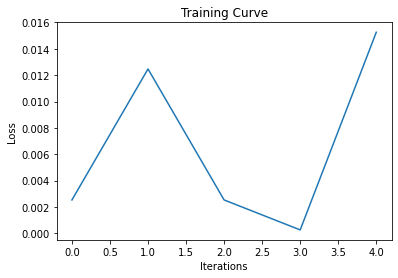

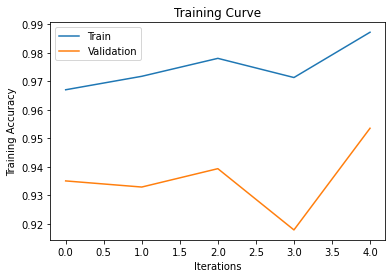

Final Training Accuracy: 0.9872638809387522
Final Validation Accuracy: 0.9535883111302106


In [ ]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  print('CUDA is available!  Training on GPU ...')

train(our_model_resnet, large_train_loader, large_val_loader, batch_size=batch_size, learn_rate=0.001, num_epochs=5)

**GoogleNet Implementation**

In [ ]:
model_google = models.googlenet(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

CUDA is available!  Training on GPU ...
CUDA is available!  Training on GPU ...
epoch number  1 training accuracy:  0.9650829994275901  and validation accuracy:  0.934250107434465
epoch number  2 training accuracy:  0.9728105323411562  and validation accuracy:  0.9480017189514396
epoch number  3 training accuracy:  0.9805380652547224  and validation accuracy:  0.9522990975504942
epoch number  4 training accuracy:  0.9738122495706926  and validation accuracy:  0.9252256123764504
epoch number  5 training accuracy:  0.976531196336577  and validation accuracy:  0.9394069617533305


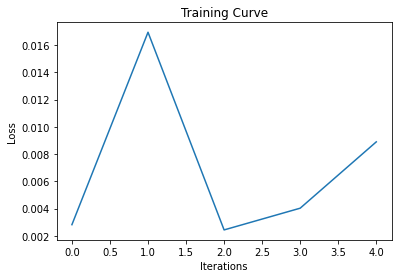

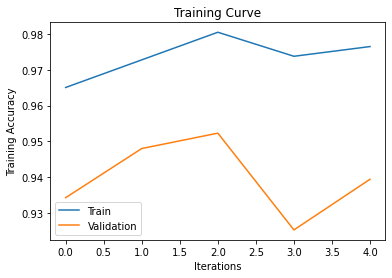

Final Training Accuracy: 0.976531196336577
Final Validation Accuracy: 0.9394069617533305


In [ ]:
if use_cuda and torch.cuda.is_available():
  model_google.cuda()
  print('CUDA is available!  Training on GPU ...')
use_cuda = True
if use_cuda and torch.cuda.is_available():
  model_google.cuda()
  print('CUDA is available!  Training on GPU ...')
 
train(model_google, large_train_loader, large_val_loader, batch_size=batch_size, learning_rate=0.001, num_epochs=5)